In [ ]:
# Bibliotecas
# teste
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import unicodedata
import re
import numpy as np
from collections import Counter
from scipy.spatial.distance import euclidean
import string
import spacy
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from nltk.corpus import stopwords
nltk.download('stopwords')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import scipy.stats as stats

[nltk_data] Downloading package stopwords to /home/ester/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [65]:
df = pd.read_csv("SMSSpamCollection", sep="\t", header=None, names=["Label", "Message"])
# header - cabecalho (None, nao tem cabecalho) #sep \t por se tratar de um arquivo tsv
display(df) #df = data frame


,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


Label
ham     4825
spam     747
Name: count, dtype: int64


<Axes: title={'center': 'Distribuição de Classes (Ham vs Spam)'}, ylabel='count'>

Text(0, 0.5, '')

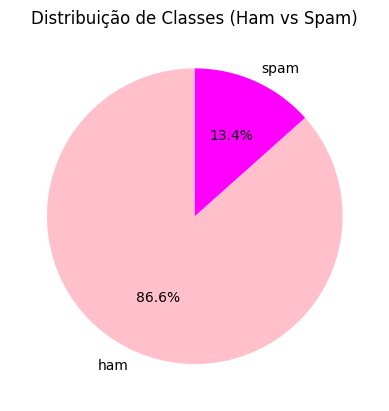

In [66]:
contagem = df['Label'].value_counts()
print(contagem)
contagem.plot(kind='pie', autopct='%1.1f%%', colors=["pink", "magenta"], title="Distribuição de Classes (Ham vs Spam)", startangle=90, legend=False)
plt.ylabel('')
plt.show()

,Label,Message,Word_count
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30
5568,ham,Will ü b going to esplanade fr home?,8
5569,ham,"Pity, * was in mood for that. So...any other s...",10
5570,ham,The guy did some bitching but I acted like i'd...,26


<Figure size 1000x600 with 0 Axes>

(array([2.152e+03, 1.661e+03, 1.252e+03, 3.960e+02, 4.600e+01, 2.200e+01,
        1.700e+01, 1.300e+01, 3.000e+00, 4.000e+00, 2.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
        110., 120., 130., 140., 150., 160., 170., 180.]),
 <BarContainer object of 18 artists>)

Text(0.5, 1.0, 'Distribuição de Documentos por Número de Palavras')

Text(0.5, 0, 'Número de Palavras')

Text(0, 0.5, 'Número de Documentos')

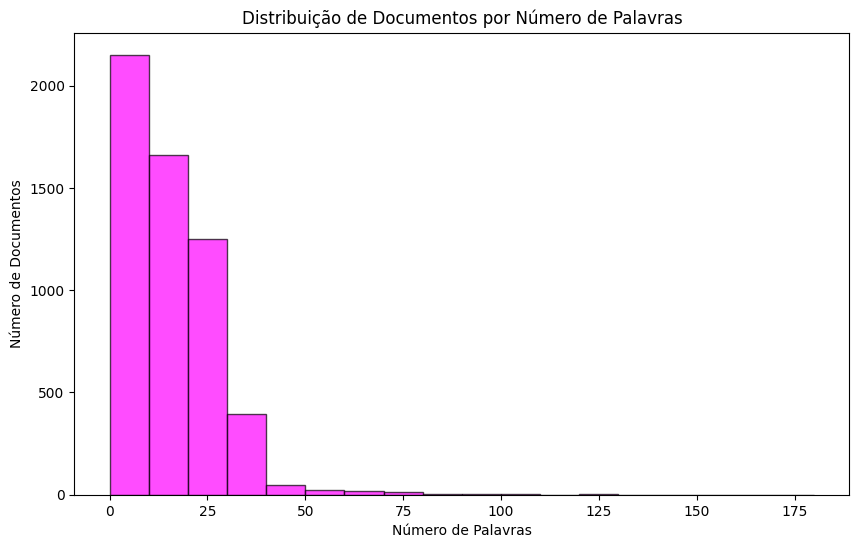

In [67]:
df["Word_count"] = df["Message"].apply(lambda x: len(x.split())) # Número de palavras por documento
# Split divide o texto em palavras usando espaço como separador
display(df)

plt.figure(figsize=(10,6))
plt.hist(df["Word_count"], bins=range(0, df["Word_count"].max() + 10, 10), edgecolor='black', color='magenta', alpha=0.7)

plt.title("Distribuição de Documentos por Número de Palavras")
plt.xlabel("Número de Palavras")
plt.ylabel("Número de Documentos")

plt.show()

In [68]:
df["Word_count"].describe() #Alguns dados
# Count: número de mensagens
# Mean: média de palavras por mensagem
# Std: desvio padrão (o quanto as mensagens variam em relação à média)
# Min: a menor mensagem tem uma palavra
# 25%: 25% das mensagens têm até 7 palavras
# Max: a maior mensagem tem 171 palavras

count    5572.000000
mean       15.597452
std        11.404053
min         1.000000
25%         7.000000
50%        12.000000
75%        23.000000
max       171.000000
Name: Word_count, dtype: float64

In [69]:
#Iniciando pré-processamento de Dados (Passo 2)

#Passo 1 - Converter para minúsculas, remover acentuação, e stopwords

def processar_etapa1(texto):
    texto = texto.lower() # Coloca tudo em minúsculo
    
    # remove acentuação
    texto = ''.join( # depois de filtrar, junta tudo de novo em uma string normal
        caractere for caractere in unicodedata.normalize('NFD', texto) # Quebra os caracteres acentuados (ex.: ç = c, cedilha)
        if unicodedata.category(caractere) != 'Mn' # Mn = Mark, Nonspacing (acentos, tils, cedilhas...)
    )
    stopwords_en = set(stopwords.words('english')) 
    tokens = texto.split() # quebra em tokens
    tokens = [t for t in tokens if t not in stopwords_en]

    return ' '.join(tokens) # junta novamente em uma string

df["Message_clean"] = df["Message"].apply(processar_etapa1)
display(df)

,Label,Message,Word_count,Message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,"go jurong point, crazy.. available bugis n gre..."
1,ham,Ok lar... Joking wif u oni...,6,ok lar... joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,11,u dun say early hor... u c already say...
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,"nah think goes usf, lives around though"
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30,2nd time tried 2 contact u. u £750 pound prize...
5568,ham,Will ü b going to esplanade fr home?,8,u b going esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s...",10,"pity, * mood that. so...any suggestions?"
5570,ham,The guy did some bitching but I acted like i'd...,26,guy bitching acted like interested buying some...


In [70]:
# Passo 2 - Remoção de marcações
df["Message_clean"] = df["Message_clean"].apply(lambda x: re.sub(r"[@#][\w@]+", "", x))
# r"[@#]\w+" -> busca o que deve ser removido
# "" -> o que deve ser substituído (nada)
display(df)


,Label,Message,Word_count,Message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,"go jurong point, crazy.. available bugis n gre..."
1,ham,Ok lar... Joking wif u oni...,6,ok lar... joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,11,u dun say early hor... u c already say...
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,"nah think goes usf, lives around though"
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30,2nd time tried 2 contact u. u £750 pound prize...
5568,ham,Will ü b going to esplanade fr home?,8,u b going esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s...",10,"pity, * mood that. so...any suggestions?"
5570,ham,The guy did some bitching but I acted like i'd...,26,guy bitching acted like interested buying some...


In [71]:
# Passo 4: remover urls (http e www)

def remover_urls(texto):
    return re.sub(r'(http[s]?://\S+|www\.\S+)', '', texto, flags=re.IGNORECASE)
    # re.sub (padrao, substituo, texto)
    # http\S+ -> pega tudo que comeca com http e segue com qualquer coisa que nao seja espaço
    # www\.\S+ -> pega tudo que comeca com www. seguido pos algo que nao seja espaço

df["Message_clean"] = df["Message_clean"].apply(remover_urls)
display(df)

,Label,Message,Word_count,Message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,"go jurong point, crazy.. available bugis n gre..."
1,ham,Ok lar... Joking wif u oni...,6,ok lar... joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,11,u dun say early hor... u c already say...
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,"nah think goes usf, lives around though"
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30,2nd time tried 2 contact u. u £750 pound prize...
5568,ham,Will ü b going to esplanade fr home?,8,u b going esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s...",10,"pity, * mood that. so...any suggestions?"
5570,ham,The guy did some bitching but I acted like i'd...,26,guy bitching acted like interested buying some...


In [72]:
# Passo 3 - Reduzir repetições (máximo duas ocorrências)
# Exemplo: boaaaaaaa -> boaa

def reduzir_repeticoes(texto):
    return re.sub(r'(.)\1{2,}', r'\1\1', texto)
    # (.) -> captura qualquer caractere
    # \1 refere-se ao mesmo caractere capturado
    # {2,} -> casa com duas ou mais repetições do mesmo caractere
    # r'\1\1 -> substitui por duas ocorrencias desse caractere

df["Message_clean"] = df["Message_clean"].apply(reduzir_repeticoes)
display(df)


,Label,Message,Word_count,Message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,"go jurong point, crazy.. available bugis n gre..."
1,ham,Ok lar... Joking wif u oni...,6,ok lar.. joking wif u oni..
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,11,u dun say early hor.. u c already say..
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,"nah think goes usf, lives around though"
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30,2nd time tried 2 contact u. u £750 pound prize...
5568,ham,Will ü b going to esplanade fr home?,8,u b going esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s...",10,"pity, * mood that. so..any suggestions?"
5570,ham,The guy did some bitching but I acted like i'd...,26,guy bitching acted like interested buying some...


In [73]:
# Passo 5: remover pontuação

df["Message_clean"] = df["Message_clean"].str.translate(str.maketrans('', '', string.punctuation))
display(df)

,Label,Message,Word_count,Message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,11,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah think goes usf lives around though
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30,2nd time tried 2 contact u u £750 pound prize ...
5568,ham,Will ü b going to esplanade fr home?,8,u b going esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",10,pity mood that soany suggestions
5570,ham,The guy did some bitching but I acted like i'd...,26,guy bitching acted like interested buying some...


In [74]:

# Passo 6: remover entidades referentes à localizações e organizações
#Esse caso é para textos em inglês
"""
nlp = spacy.load("en_core_web_sm")

entidades_para_remover = {"ORG", "GPE", "LOC"}

def remover_entidades(texto):
    doc = nlp(texto)
    indices_para_remover = set()
    
    for ent in doc.ents:
        if ent.label_ in entidades_para_remover:
            for token in ent:
                indices_para_remover.add(token.i)
    
    tokens_filtrados = [token.text for i, token in enumerate(doc) if i not in indices_para_remover]
    return " ".join(tokens_filtrados)

df["Message_clean"] = df["Message_clean"].apply(remover_entidades)
display(df)
"""

'\nnlp = spacy.load("en_core_web_sm")\n\nentidades_para_remover = {"ORG", "GPE", "LOC"}\n\ndef remover_entidades(texto):\n    doc = nlp(texto)\n    indices_para_remover = set()\n    \n    for ent in doc.ents:\n        if ent.label_ in entidades_para_remover:\n            for token in ent:\n                indices_para_remover.add(token.i)\n    \n    tokens_filtrados = [token.text for i, token in enumerate(doc) if i not in indices_para_remover]\n    return " ".join(tokens_filtrados)\n\ndf["Message_clean"] = df["Message_clean"].apply(remover_entidades)\ndisplay(df)\n'

In [75]:
# Etapa 7: remover tokens numéricos

def remover_tokens_numericos(texto):
    tokens = texto.split()
    tokens_sem_numeros = [t for t in tokens if not re.search(r'\d', t)]
    return ' '.join(tokens_sem_numeros)

df["Message_clean"] = df["Message_clean"].apply(remover_tokens_numericos)
display(df)

,Label,Message,Word_count,Message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry wkly comp win fa cup final tkts may...
3,ham,U dun say so early hor... U c already then say...,11,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah think goes usf lives around though
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30,time tried contact u u pound prize claim easy ...
5568,ham,Will ü b going to esplanade fr home?,8,u b going esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",10,pity mood that soany suggestions
5570,ham,The guy did some bitching but I acted like i'd...,26,guy bitching acted like interested buying some...


In [76]:
# Etapa 8: remover palavras com menos de 3 caracteres

def remover_palavras_curtas(texto):
    tokens = texto.split()
    tokens_sem_palavras_curtas = [t for t in tokens if len(t) >= 3]
    return ' '.join(tokens_sem_palavras_curtas)

df["Message_clean"] = df["Message_clean"].apply(remover_palavras_curtas)
display(df)


,Label,Message,Word_count,Message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,jurong point crazy available bugis great world...
1,ham,Ok lar... Joking wif u oni...,6,lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry wkly comp win cup final tkts may te...
3,ham,U dun say so early hor... U c already then say...,11,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah think goes usf lives around though
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30,time tried contact pound prize claim easy call...
5568,ham,Will ü b going to esplanade fr home?,8,going esplanade home
5569,ham,"Pity, * was in mood for that. So...any other s...",10,pity mood that soany suggestions
5570,ham,The guy did some bitching but I acted like i'd...,26,guy bitching acted like interested buying some...


In [77]:
# Etapa 9: remover nomes pessoais
'''
nlp = spacy.load("en_core_web_sm")

def remover_nomes_pessoais(texto):
    doc = nlp(texto)
    texto_sem_nomes = [token.text for token in doc if token.ent_type_ != "PERSON"]
    return " ".join(texto_sem_nomes)

df["Message_clean"] = df["Message_clean"].apply(remover_nomes_pessoais)
display(df)
'''

'\nnlp = spacy.load("en_core_web_sm")\n\ndef remover_nomes_pessoais(texto):\n    doc = nlp(texto)\n    texto_sem_nomes = [token.text for token in doc if token.ent_type_ != "PERSON"]\n    return " ".join(texto_sem_nomes)\n\ndf["Message_clean"] = df["Message_clean"].apply(remover_nomes_pessoais)\ndisplay(df)\n'

In [78]:
# Lematização
"""
nlp = spacy.load("en_core_web_sm")

def lematizacao(texto):
    doc = nlp(texto)
    tokens_lematizados = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens_lematizados)

df["Message_clean"] = df["Message_clean"].apply(lematizacao)
display(df)
"""

'\nnlp = spacy.load("en_core_web_sm")\n\ndef lematizacao(texto):\n    doc = nlp(texto)\n    tokens_lematizados = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]\n    return " ".join(tokens_lematizados)\n\ndf["Message_clean"] = df["Message_clean"].apply(lematizacao)\ndisplay(df)\n'

,Label,Message,Word_count,Message_clean,Word_count_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,jurong point crazy available bugis great world...,12
1,ham,Ok lar... Joking wif u oni...,6,lar joking wif oni,4
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry wkly comp win cup final tkts may te...,16
3,ham,U dun say so early hor... U c already then say...,11,dun say early hor already say,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah think goes usf lives around though,7
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,30,time tried contact pound prize claim easy call...,11
5568,ham,Will ü b going to esplanade fr home?,8,going esplanade home,3
5569,ham,"Pity, * was in mood for that. So...any other s...",10,pity mood that soany suggestions,5
5570,ham,The guy did some bitching but I acted like i'd...,26,guy bitching acted like interested buying some...,12


<Figure size 1000x600 with 0 Axes>

(array([3.760e+03, 1.675e+03, 9.600e+01, 3.000e+01, 2.000e+00, 6.000e+00,
        2.000e+00, 1.000e+00]),
 array([ 0., 10., 20., 30., 40., 50., 60., 70., 80.]),
 <BarContainer object of 8 artists>)

Text(0.5, 1.0, 'Distribuição de Documentos por Número de Palavras')

Text(0.5, 0, 'Número de Palavras')

Text(0, 0.5, 'Número de Documentos')

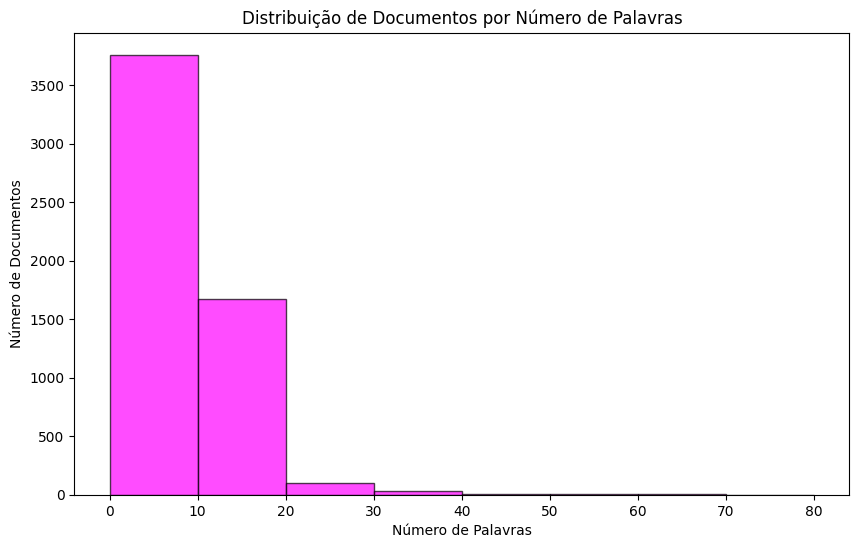

In [79]:
df["Word_count_clean"] = df["Message_clean"].apply(lambda x: len(x.split())) # Número de palavras por documento
# Split divide o texto em palavras usando espaço como separador
display(df)

plt.figure(figsize=(10,6))
plt.hist(df["Word_count_clean"], bins=range(0, df["Word_count_clean"].max() + 10, 10), edgecolor='black', color='magenta', alpha=0.7)

plt.title("Distribuição de Documentos por Número de Palavras")
plt.xlabel("Número de Palavras")
plt.ylabel("Número de Documentos")

plt.show()


In [80]:
# Passo 3: Representação TF-IDF 

X = df["Message_clean"] # Dados de entrada, mensagens pré-processadas
y = df["Label"] # Rótulos ham ou spam

codificador = LabelEncoder()
y_codificado = codificador.fit_transform(y) # Convertendo rótulos textuais para inteiros
# ham = 0, spam = 1

# Dividindo em 80% treino e 20% teste
X_train, X_test, y_train, y_test = train_test_split(X, y_codificado, test_size=0.2, random_state=0)

# Criando o vetor TF-IDF para converter texto em vetores numéricos
vectorizer = TfidfVectorizer()

# Apredne o vocabulário com base no treino e transforma em vetores TF-IDF
X_train_tfidf = vectorizer.fit_transform(X_train)

# Somente aplica o vocabulário aprendido com X_train para transformar os dados de teste
X_test_tfidf = vectorizer.transform(X_test)
# Ou seja, palavras que aparecem só em X_test serão ignoradas

print("Vocabulário:", vectorizer.get_feature_names_out()[:20])
print(X_train_tfidf.toarray())
print(X_test_tfidf.toarray())


Vocabulário: ['aah' 'aaniye' 'aaooright' 'aathilove' 'aathiwhere' 'abbey' 'abelu'
 'aberdeen' 'abi' 'ability' 'abiola' 'abj' 'able' 'about' 'abroad'
 'absence' 'abstract' 'abt' 'abta' 'aburo']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [81]:
# Passo 4 - Classificação
# Árvore de decisão

def arvore_de_decisao(X_train, y_train, X_test, y_test):
    parametros = {
        'criterion': ['gini', 'entropy'], # Função usada para medir a qualidade de uma divisão
        'max_depth': [None, 10, 20], # Profundidade máxima 
        'min_samples_split': [2, 5, 10], # Mínimo de amostras exigido para dividir um nó
        'min_samples_leaf': [1, 2, 4] # Mínimo de amostras exigido em um nó folha
    }

    # Treinando a árvore de decisão
    clf = tree.DecisionTreeClassifier()

    grid_search = GridSearchCV(estimator=clf, param_grid=parametros, cv=5, scoring='accuracy')
    #cv =5 significa que os dados sao divididos em 5 partes. O modelo é treinado 5 vezes, utilizando 4 partes
    # para treino.

    grid_search.fit(X_train, y_train) # Treina o modelo utilizando os melhores parametros encontrados

    print("Melhores parâmetros: ", grid_search.best_params_)

    melhor_clf = grid_search.best_estimator_ # treina novamente com os melhores parametros
    y_pred = melhor_clf.predict(X_test) # Fazendo a previsão no conjunto de teste

    acuracia = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')

    print(f"\nAcurácia com os melhores parâmetros: {acuracia}")
    print(f"F1 Score (macro) com os melhores parâmetros: {f1_macro}")

    #plt.figure(figsize=(20,10))
    #tree.plot_tree(melhor_clf, max_depth=2, feature_names=vectorizer.get_feature_names_out(), class_names=codificador.classes_, filled=True)
    #plt.show()
    # max_depth profundidade da árvore
    # filled=True colore os nós de acordo com a classe predominante
    # feature_names mostra quais palavras sao mais importantes para as decisoes

    return grid_search.best_params_


In [82]:
# Explicando a árvore exibida
# call <= 0.108 Critério de divisão: se a frequência da palavra "call" for menor ou igual a 0.108 vai para a esquerda (mais provável ser ham)
# gini = 0.229 Medida de impureza do nó. Quanto menor, mais concentrado em uma única classe.
# samples = 4457 Quantidade de mensagens analisadas nese nó
# value = [3870, 587] 3870 são ham e 587 são spam

# Laranja: a classe predominante é ham, Azul: spam. Quanto mais intensa a cor, contém mais exemplos da mesma classe

In [83]:
# KNN - K-Nearest Neighbor

def knn(X_train, y_train, X_test, y_test):
    parametros = {'n_neighbors': [1, 3, 5, 7, 9],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan']}

    # Aplicando KNN
    knn = KNeighborsClassifier()

    grid_search = GridSearchCV(estimator=knn, param_grid=parametros, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train) # Treina o modelo com diferentes combinações
    print("Melhores parâmetros: ", grid_search.best_params_)

    melhor_knn = grid_search.best_estimator_
    melhor_y_pred = melhor_knn.predict(X_test) # Realiza predições com o modelo ajustado

    acuracia = accuracy_score(y_test, melhor_y_pred)
    f1_macro = f1_score(y_test, melhor_y_pred, average='macro')

    print(f"Acurácia com os melhores parâmetros: {acuracia}")
    print(f"F1 Score (macro) com os melhores parâmetros: {f1_macro}")

    return grid_search.best_params_



In [84]:
# KNN - na mão

def knn_manual(X_train, y_train, X_test, y_test, k):

    # Calcula a distância euclidiana entre dois vetores 
    def distancia_euclidiana(x1, x2):
        # Converte as duas entradas para arrays densos 1D
        return euclidean(x1.toarray().flatten(), x2.toarray().flatten())

    # Retorna a classe prevista para um exemplo de teste com base nos k vizinhos mais próximos
    def classe_prevista(X_train, y_train, X_test, k):
        distancias = []

        # Calcula a distância entre o exemplo de teste e todos os outros exemplos de treino
        for i in range(X_train.shape[0]):
            distancia = distancia_euclidiana(X_test, X_train[i])
            distancias.append((distancia, y_train[i]))

        distancias.sort(key=lambda x: x[0]) # Ordena pela menor distância
        k_neighboors = distancias[:k] # Seleciona os k mais próximos
        classes = [label for _, label in k_neighboors]
        classe_mais_frequente = Counter(classes).most_common(1)

        return classe_mais_frequente[0][0]

    def avaliacao_knn(X_train, y_train, X_test, y_test, k):
        certo = 0 # Contador de predições corretas

        # Para cada teste, compara com o rótulo verdadeiro
        for i in range(X_test.shape[0]):
            pred = classe_prevista(X_train, y_train, X_test[i], k)
            if pred == y_test[i]:
                certo += 1

        acuracia = certo / X_test.shape[0]
        print(f"Acurácia com K={k}: {acuracia}")
        return acuracia

    avaliacao_knn(X_train, y_train, X_test, y_test, k=5)

In [85]:
# SVM 

def svm_modelo(X_train, y_train, X_test, y_test):
    parametros = {
        'C': [1, 10],  # Parâmetro C
        'gamma': [0.1, 'auto', 'scale'],  # Parâmetro gamma
        'kernel': ['rbf', 'linear']  # Tipos de kernel
    }
    # Parâmetro C pequeno tolera mais erros (evita overfitting) - está com valor padrão
    # Parâmetro gamma pequeno define que cada ponto de treino tem influencia ampla resultando em 
    # uma fronteira maior - está com valor padrão

    svc = svm.SVC()

    grid_search = GridSearchCV(estimator=svc, param_grid=parametros, cv=5, scoring='accuracy')

    grid_search.fit(X_train, y_train)

    print(f"Melhores parâmetros encontrados: {grid_search.best_params_}")

    # Fazendo a previsão com os melhores parametros
    melhor_svm = grid_search.best_estimator_
    y_pred = melhor_svm.predict(X_test)

    print(f"Acurácia: {accuracy_score(y_test, y_pred)}")
    f1_macro = f1_score(y_test, y_pred, average='macro')
    print(f"F1-Score Macro: {f1_macro}")

    return grid_search.best_params_




In [86]:
def calcular_intervalo_confianca(valores):
    media = np.mean(valores)
    desvio_padrao = np.std(valores)
    n = len(valores)

    t_critico = stats.t.ppf(0.975, df=n-1) # t Student (95% de confiança)

    erro_padrao = desvio_padrao/np.sqrt(n)

    intervalo_confianca = t_critico * erro_padrao

    return media, desvio_padrao, intervalo_confianca

def comparar_modelos_teste_t(resultados):
    # Converte as chaves do dicionário 'resultados' em uma lista de modelos
    modelos = list(resultados.keys())
    acuracias = [resultados[modelo] for modelo in modelos]

    valores_p = []

    # Comparar todos os pares de modelos com o teste t
    for i in range(len(modelos)):
        for j in range(i+1, len(modelos)):
            # Realiza o Teste T entre os dois modelos e extrai o valor p
            _, valor_p = stats.ttest_ind(acuracias[i], acuracias[j])
            valores_p.append(valor_p)
            print(f"Teste T entre {modelos[i]} e {modelos[j]}: valor_p = {valor_p:.4f}")

    # Correção de Bonferroni: ajusta o valor p para múltiplas comparações
    bonferroni_valores_p = [p * len(valores_p) for p in valores_p]

    # Loop para exibir os valores p corrigidos pelo método de Bonferroni
    for i, p in enumerate(bonferroni_valores_p):
        # Calcular corretamente os pares de modelos
        modelo1 = modelos[i // (len(modelos) - 1)]
        modelo2 = modelos[i % (len(modelos) - 1) + 1]
        
        print(f"P-value corrigido Bonferroni ({modelo1} vs {modelo2}): {p:.4f}")
        if p < 0.05:
            print("Os métodos são estatisticamente diferentes.")
        else:
            print("Os métodos são estatisticamente equivalentes.")

In [87]:
# Holdout

def holdout(modelo_cls, X, y, rep, test_size=0.2, best_params=None):
    print("\n --- Holdout --- ")
    acuracias = []
    f1_scores = []

    for i in range(rep):
        print(f"\nRepetição {i}:")

        # Divide os dados vetorizados diretamente
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i)

        # Instancia o modelo com os melhores parâmetros (se houver)
        modelo = modelo_cls(**best_params) if best_params else modelo_cls()

        # Treinamento e predição
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        # Métricas
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        acuracias.append(acc)
        f1_scores.append(f1)

        print(f"  Acurácia: {acc}")
        print(f"  F1 Score (macro): {f1}")

    print("\nMÉDIA FINAL HOLDOUT:")
    acuracia_media, acuracia_desvio, acuracia_ic = calcular_intervalo_confianca(acuracias)
    f1_media, f1_desvio, f1_ic = calcular_intervalo_confianca(f1_scores)

    print(f"  Acurácia média: {acuracia_media:.4f} (± {acuracia_ic:.4f})")
    print(f"  Desvio padrão da Acurácia: {acuracia_desvio:.4f}")
    print(f"  F1 Score (macro) médio: {f1_media:.4f} (± {f1_ic:.4f})")
    print(f"  Desvio padrão do F1 Score (macro): {f1_desvio:.4f}")

    return acuracias, f1_scores


In [88]:
# Stratified K Fold

def stratified_k_fold(modelo, X, y, best_params, k=10):
    print("\n --- Stratified K Fold ---")
    skf = StratifiedKFold(n_splits=k)
    acuracias = []
    f1_scores = []

    for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"Fold {i}:")
        
        # Dividindo os dados em treino e teste
        X_fold_train, X_fold_test = X[train_idx], X[test_idx]
        y_fold_train, y_fold_test = y[train_idx], y[test_idx]

        X_fold_train_tfidf = X_fold_train
        X_fold_test_tfidf = X_fold_test 

        # Inicializando o modelo com os melhores parâmetros
        clf_fold = modelo(**best_params) if (best_params) else modelo()
        
        # Treinando o modelo
        clf_fold.fit(X_fold_train_tfidf, y_fold_train)

        # Predição
        y_pred_fold = clf_fold.predict(X_fold_test_tfidf)

        # Calculando as métricas
        acc = accuracy_score(y_fold_test, y_pred_fold)
        f1 = f1_score(y_fold_test, y_pred_fold, average='macro')

        # Armazenando os resultados
        acuracias.append(acc)
        f1_scores.append(f1)

        # Exibindo os resultados por fold
        print(f"  Acurácia do Fold {i}: {acc}")
        print(f"  F1 Score (macro) do Fold {i}: {f1}")

    acuracia_media, acuracia_desvio, acuracia_ic = calcular_intervalo_confianca(acuracias)
    f1_media, f1_desvio, f1_ic = calcular_intervalo_confianca(f1_scores)

    # Exibindo as métricas médias
    print(f"\nAcurácia média após K-Fold: {acuracia_media:.4f} (± {acuracia_ic:.4f})")
    print(f"F1 Score (macro) médio após K-Fold: {f1_media:.4f} (± {f1_ic:.4f})")
    print(f"  Desvio padrão da Acurácia: {acuracia_desvio:.4f}")
    print(f"  Desvio padrão do F1 Score (macro): {f1_desvio:.4f}")


In [89]:
# Concatenando treino e teste novamente para o KFold (reutilizando o vetor completo)
X_tfidf_total = vectorizer.transform(X)


print("\n--- ÁRVORE DE DECISÃO ---")
melhores_parametros_arvore = arvore_de_decisao(X_train_tfidf, y_train, X_test_tfidf, y_test)
stratified_k_fold(DecisionTreeClassifier, X_tfidf_total, y_codificado, melhores_parametros_arvore, 10)
resultados_arvore = holdout(DecisionTreeClassifier, X_tfidf_total, y_codificado, 3, 0.2, melhores_parametros_arvore)



--- ÁRVORE DE DECISÃO ---
Melhores parâmetros:  {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}

Acurácia com os melhores parâmetros: 0.957847533632287
F1 Score (macro) com os melhores parâmetros: 0.9097444323311443

 --- Stratified K Fold ---
Fold 0:
  Acurácia do Fold 0: 0.9731182795698925
  F1 Score (macro) do Fold 0: 0.9419084833047618
Fold 1:
  Acurácia do Fold 1: 0.953405017921147
  F1 Score (macro) do Fold 1: 0.8938231850117095
Fold 2:
  Acurácia do Fold 2: 0.9712746858168761
  F1 Score (macro) do Fold 2: 0.9354315191560888
Fold 3:
  Acurácia do Fold 3: 0.9605026929982047
  F1 Score (macro) do Fold 3: 0.909019363269185
Fold 4:
  Acurácia do Fold 4: 0.9658886894075404
  F1 Score (macro) do Fold 4: 0.921911086515403
Fold 5:
  Acurácia do Fold 5: 0.9658886894075404
  F1 Score (macro) do Fold 5: 0.9209332904989951
Fold 6:
  Acurácia do Fold 6: 0.9497307001795332
  F1 Score (macro) do Fold 6: 0.8870051585231554
Fold 7:
  Acurácia do Fold 7: 0

In [90]:
print("\n--- KNN ---")
melhores_parametros_knn = knn(X_train_tfidf, y_train, X_test_tfidf, y_test)
stratified_k_fold(KNeighborsClassifier, X_tfidf_total, y_codificado, melhores_parametros_knn or {}, 10)
resultados_knn = holdout(KNeighborsClassifier, X_tfidf_total, y_codificado, 3, 0.2, melhores_parametros_knn) 



--- KNN ---
Melhores parâmetros:  {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Acurácia com os melhores parâmetros: 0.9551569506726457
F1 Score (macro) com os melhores parâmetros: 0.8946523053665911

 --- Stratified K Fold ---
Fold 0:
  Acurácia do Fold 0: 0.953405017921147
  F1 Score (macro) do Fold 0: 0.8820564516129032
Fold 1:
  Acurácia do Fold 1: 0.9480286738351255
  F1 Score (macro) do Fold 1: 0.8655924249345903
Fold 2:
  Acurácia do Fold 2: 0.9425493716337523
  F1 Score (macro) do Fold 2: 0.8483425226329044
Fold 3:
  Acurácia do Fold 3: 0.9497307001795332
  F1 Score (macro) do Fold 3: 0.8692488262910798
Fold 4:
  Acurácia do Fold 4: 0.947935368043088
  F1 Score (macro) do Fold 4: 0.8635783961825936
Fold 5:
  Acurácia do Fold 5: 0.9461400359066428
  F1 Score (macro) do Fold 5: 0.8599094567404426
Fold 6:
  Acurácia do Fold 6: 0.9461400359066428
  F1 Score (macro) do Fold 6: 0.8619282125859333
Fold 7:
  Acurácia do Fold 7: 0.9515260323159784
  F1 Score (macro) 

In [91]:
print("\n--- SVM ---")
melhores_parametros_svm = svm_modelo(X_train_tfidf, y_train, X_test_tfidf, y_test)
stratified_k_fold(SVC, X_tfidf_total, y_codificado, melhores_parametros_svm, 10)
resultados_svm = holdout(SVC, X_tfidf_total, y_codificado, 3, 0.2, melhores_parametros_svm)



--- SVM ---
Melhores parâmetros encontrados: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Acurácia: 0.9847533632286996
F1-Score Macro: 0.9677155631253992

 --- Stratified K Fold ---
Fold 0:
  Acurácia do Fold 0: 0.9838709677419355
  F1 Score (macro) do Fold 0: 0.964331119713058
Fold 1:
  Acurácia do Fold 1: 0.9802867383512545
  F1 Score (macro) do Fold 1: 0.9553518821603928
Fold 2:
  Acurácia do Fold 2: 0.9802513464991023
  F1 Score (macro) do Fold 2: 0.9542245366046813
Fold 3:
  Acurácia do Fold 3: 0.9820466786355476
  F1 Score (macro) do Fold 3: 0.9586451651223569
Fold 4:
  Acurácia do Fold 4: 0.9766606822262118
  F1 Score (macro) do Fold 4: 0.9452124238641093
Fold 5:
  Acurácia do Fold 5: 0.9730700179533214
  F1 Score (macro) do Fold 5: 0.9375789135518382
Fold 6:
  Acurácia do Fold 6: 0.9838420107719928
  F1 Score (macro) do Fold 6: 0.9634602348516323
Fold 7:
  Acurácia do Fold 7: 0.9784560143626571
  F1 Score (macro) do Fold 7: 0.9503741981468282
Fold 8:
  Acurácia do Fold 8: 0.983842

In [92]:
resultados_comparacao = {
    'Árvore de Decisão': resultados_arvore[0],
    'KNN': resultados_knn[0],
    'SVM': resultados_svm[0]
}

comparar_modelos_teste_t(resultados_comparacao)

Teste T entre Árvore de Decisão e KNN: valor_p = 0.1827
Teste T entre Árvore de Decisão e SVM: valor_p = 0.0050
Teste T entre KNN e SVM: valor_p = 0.0051
P-value corrigido Bonferroni (Árvore de Decisão vs KNN): 0.5481
Os métodos são estatisticamente equivalentes.
P-value corrigido Bonferroni (Árvore de Decisão vs SVM): 0.0150
Os métodos são estatisticamente diferentes.
P-value corrigido Bonferroni (KNN vs KNN): 0.0152
Os métodos são estatisticamente diferentes.
